In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest

In [2]:
data = pd.read_csv("bankruptcy.csv")

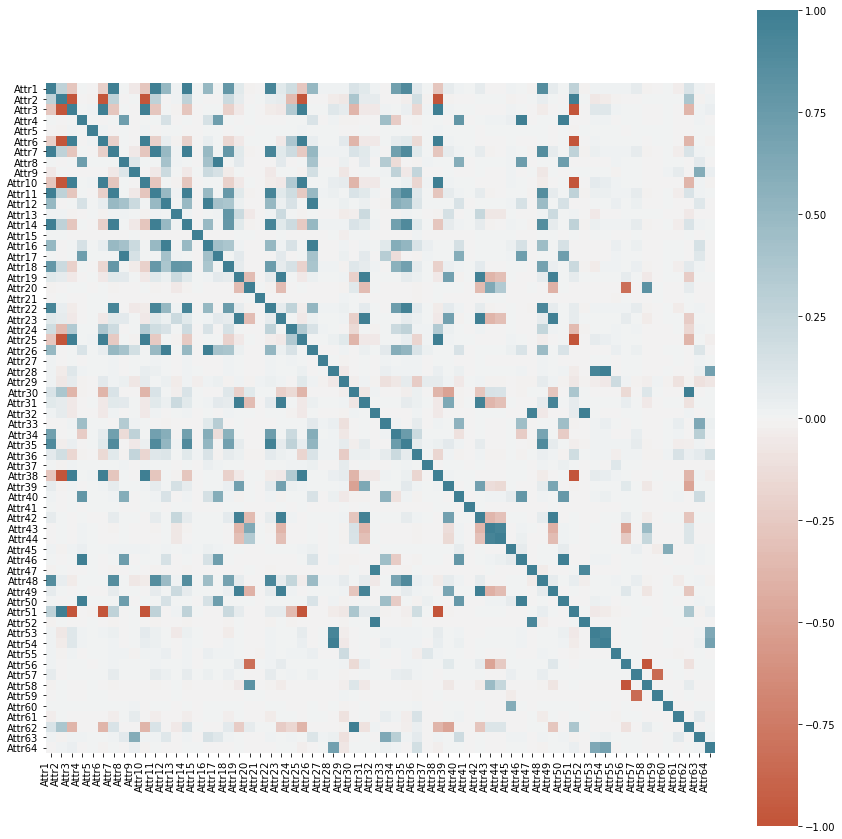

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [4]:
data.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [5]:
data.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,8.822900e+02,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,4.348900e+03,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,3.380500e+06,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000


In [6]:
data["class"].unique()

array(["b'0'", "b'1'"], dtype=object)

In [7]:
datanew = data.replace(["b'0'", "b'1'"], [0,1])

In [8]:
datanew["class"].unique()

array([0, 1], dtype=int64)

In [9]:
datanew.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


In [10]:
datanew.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800,0.047129
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300,0.000000
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750,0.000000
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000,1.000000


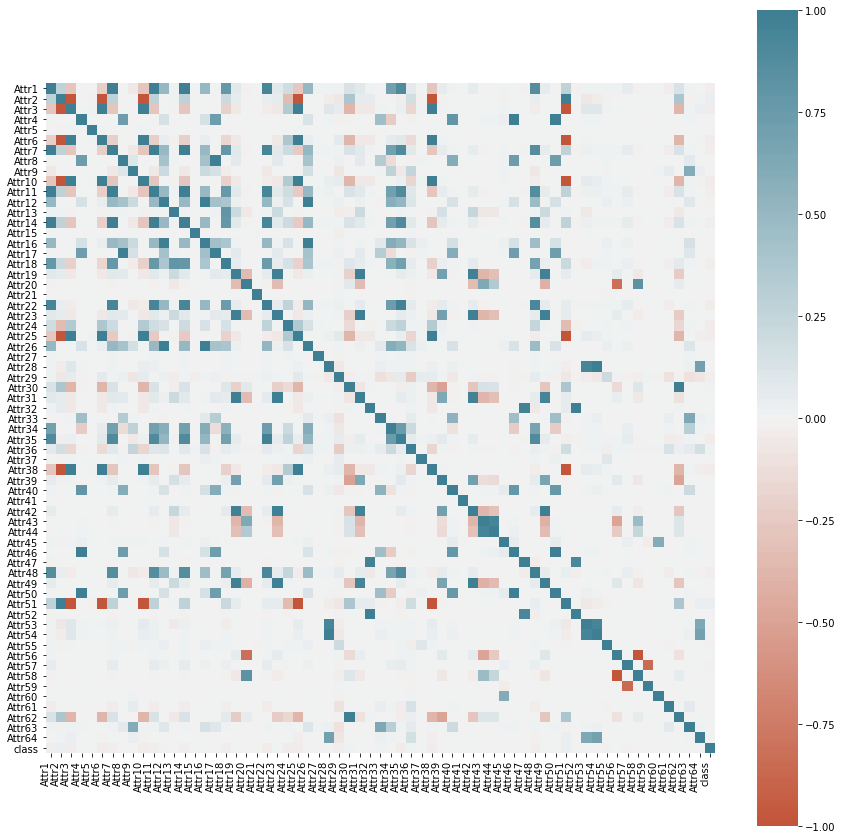

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
corr = datanew.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [12]:
datanew = datanew.replace('', np.nan)

In [13]:
np.where(pd.isnull(datanew))

(array([    1,     1,     2, ..., 10500, 10501, 10501], dtype=int64),
 array([23, 36, 36, ..., 20, 26, 36], dtype=int64))

In [14]:
missingValues = datanew.columns[datanew.isna().any()].tolist()

In [15]:
missingValues

['Attr4',
 'Attr5',
 'Attr8',
 'Attr9',
 'Attr12',
 'Attr13',
 'Attr15',
 'Attr16',
 'Attr17',
 'Attr19',
 'Attr20',
 'Attr21',
 'Attr23',
 'Attr24',
 'Attr26',
 'Attr27',
 'Attr28',
 'Attr30',
 'Attr31',
 'Attr32',
 'Attr33',
 'Attr34',
 'Attr37',
 'Attr39',
 'Attr40',
 'Attr41',
 'Attr42',
 'Attr43',
 'Attr44',
 'Attr45',
 'Attr46',
 'Attr47',
 'Attr49',
 'Attr50',
 'Attr52',
 'Attr53',
 'Attr54',
 'Attr56',
 'Attr58',
 'Attr60',
 'Attr61',
 'Attr62',
 'Attr63',
 'Attr64']

In [16]:
missing_values_total = pd.DataFrame(datanew, columns=missingValues).isnull().sum()
missing_values_total

Attr4       18
Attr5       25
Attr8       14
Attr9        3
Attr12      18
Attr13      43
Attr15       8
Attr16      14
Attr17      14
Attr19      43
Attr20      43
Attr21     807
Attr23      43
Attr24     227
Attr26      14
Attr27     715
Attr28     228
Attr30      43
Attr31      43
Attr32     101
Attr33      18
Attr34      14
Attr37    4736
Attr39      43
Attr40      18
Attr41     202
Attr42      43
Attr43      43
Attr44      43
Attr45     591
Attr46      18
Attr47      86
Attr49      43
Attr50      14
Attr52      86
Attr53     228
Attr54     228
Attr56      43
Attr58      29
Attr60     592
Attr61      17
Attr62      43
Attr63      18
Attr64     228
dtype: int64

<AxesSubplot:>

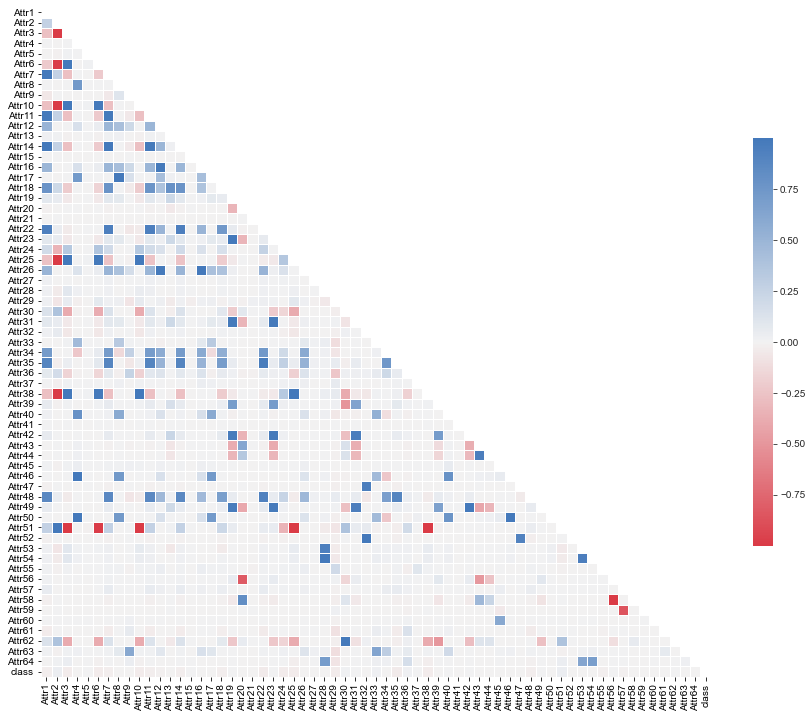

In [17]:
# visualise the data with seaborn
corr = datanew.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig1, ax1 = plt.subplots(figsize=(15, 15))
sns.set_style(style = 'white')
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

In [45]:
skewnes_arr = datanew.skew(axis = 0, skipna = True).tolist()
skewnes_arr

[51.97174974308479,
 71.59601916882427,
 -71.69157647082191,
 101.3057860498334,
 -96.85758241817236,
 -69.36731120644359,
 51.12249330955251,
 57.590690573125485,
 89.23915209296678,
 -71.53233877920705,
 50.325598665638665,
 63.80065070710139,
 95.39993809123469,
 51.12260821401317,
 78.01677587973454,
 66.17821155113656,
 56.86345383996978,
 49.39102671913184,
 -55.99039915461082,
 72.00940147254654,
 96.5174401226808,
 49.43607129465748,
 -56.753416332372026,
 58.74031498663814,
 -70.65884267125817,
 68.08415261541403,
 58.57875077981037,
 40.28119242910751,
 -0.03026622326117989,
 -58.691195325310076,
 -56.905898024454444,
 91.09697258856326,
 49.97140962126055,
 75.07516596312007,
 52.688412772595605,
 31.606762507332743,
 50.65384594349361,
 -71.68493881475142,
 -52.582873781295014,
 53.74957520781755,
 101.48319857882076,
 -57.841189664183965,
 61.55641862619446,
 78.29130489988319,
 39.39154083453947,
 101.38405615070258,
 74.4858141970334,
 38.21777094168015,
 -60.75335143405